# Imports

In [20]:
import pandas as pd
import random
import numpy as np
import time
import matplotlib.pyplot as plt

# Load city coordinates
cities = pd.read_csv("data/cities.csv")
coords = cities[['X', 'Y']].values

# Compute distance matrix
dist_matrix = np.sqrt(((coords[:, None, :] - coords[None, :, :]) ** 2).sum(axis=2))

N = len(coords) # N is the number of cities in the TSP problem


# HillClimber

The Hill Climber algorithm is a single-solution-driven search method.
We represent a candidate solution as a permutation of cities and iteratively improve it by swapping two cities at random, accepting the new solution if it results in a shorter total distance.
Solution class: stores the route and computes the total distance.
hill_climber function: performs the local search for a fixed number of iterations (LOOPS).

The Iterated Local Search (ILS) used here is a variant of the Hill Climber that extends its capabilities by periodically perturbing the current solution to escape local optima.
This makes it more robust for complex optimization problems like the TSP, where simple hill climbing can quickly get trapped in suboptimal solutions.

In [21]:
# ==============================
# Hyperparameters (tunable)
# ==============================
LOOPS = 20000  # Number of iterations for hill climbing
OUTER_LOOPS = 50         # number of iterations for ILS outer loop
PERTURB_STRENGTH = 2     # number of segments to perturb per iteration



# ==============================
# Solution class
# ==============================
class Solution:
    def __init__(self, route=None):
        if route is None:
            self.route = random.sample(range(N), N)
        else:
            self.route = route
        self.utility = self.evaluate()

    def evaluate(self):
        """Compute total route distance"""
        return sum(dist_matrix[self.route[i]][self.route[(i + 1) % N]] for i in range(N))

# ==============================
# Hill Climber
# ==============================
def hill_climber(start_route=None):
    current = Solution(start_route)
    best_scores = []

    for _ in range(LOOPS):
        new_route = current.route.copy()
        i, j = random.sample(range(N), 2)
        new_route[i], new_route[j] = new_route[j], new_route[i]

        neighbor = Solution(new_route)
        if neighbor.utility < current.utility:
            current = neighbor

        best_scores.append(current.utility)

    return current, best_scores

# ==============================
# Perturbation for ILS
# ==============================
def perturb(route, strength=PERTURB_STRENGTH):
    new_route = route.copy()
    for _ in range(strength):
        i, j = sorted(random.sample(range(N), 2))
        new_route[i:j] = reversed(new_route[i:j])
    return new_route

# ==============================
# Iterated Local Search
# ==============================
def iterated_local_search(outer_loops=OUTER_LOOPS, perturb_strength=PERTURB_STRENGTH):
    start_time = time.time()

    best_solution, _ = hill_climber()
    best_distance = best_solution.utility
    all_best = [best_distance]

    for iteration in range(outer_loops):
        perturbed_route = perturb(best_solution.route, perturb_strength)
        new_solution, _ = hill_climber(perturbed_route)

        if new_solution.utility < best_distance:
            best_solution = new_solution
            best_distance = new_solution.utility

        all_best.append(best_distance)
        print(f"ILS Iteration {iteration+1}/{outer_loops} - Best Distance: {best_distance:.2f}")

    end_time = time.time()
    runtime = end_time - start_time

    

    return best_solution, all_best, runtime


ILS Iteration 1/50 - Best Distance: 817.37
ILS Iteration 2/50 - Best Distance: 817.37
ILS Iteration 3/50 - Best Distance: 720.77
ILS Iteration 4/50 - Best Distance: 720.77
ILS Iteration 5/50 - Best Distance: 711.09
ILS Iteration 6/50 - Best Distance: 706.87
ILS Iteration 7/50 - Best Distance: 706.87
ILS Iteration 8/50 - Best Distance: 706.87
ILS Iteration 9/50 - Best Distance: 706.87
ILS Iteration 10/50 - Best Distance: 706.87
ILS Iteration 11/50 - Best Distance: 706.87
ILS Iteration 12/50 - Best Distance: 706.87
ILS Iteration 13/50 - Best Distance: 706.87
ILS Iteration 14/50 - Best Distance: 706.87
ILS Iteration 15/50 - Best Distance: 706.87
ILS Iteration 16/50 - Best Distance: 706.87
ILS Iteration 17/50 - Best Distance: 695.35
ILS Iteration 18/50 - Best Distance: 695.35
ILS Iteration 19/50 - Best Distance: 695.35
ILS Iteration 20/50 - Best Distance: 695.35
ILS Iteration 21/50 - Best Distance: 675.30
ILS Iteration 22/50 - Best Distance: 675.30
ILS Iteration 23/50 - Best Distance: 675.

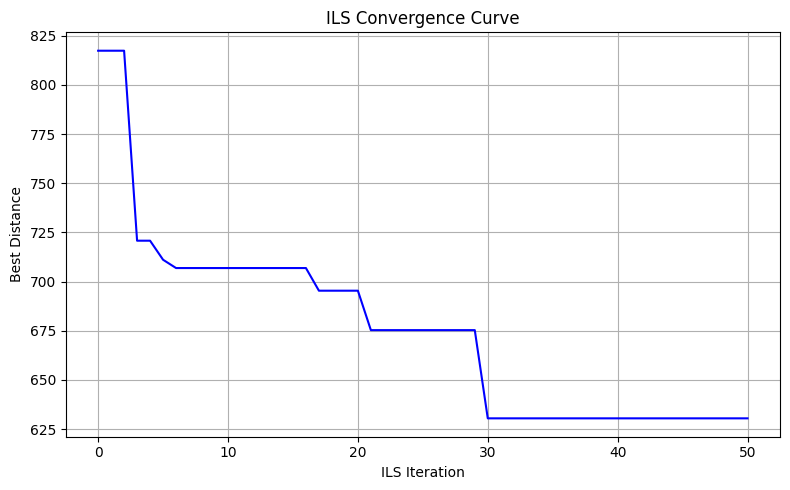

Convergence plot saved to ils_convergence_plot.png


In [22]:
# ==============================
# Run ILS once and save results
# ==============================
best_solution, convergence, runtime = iterated_local_search()

# Print results
print(f"Best Distance: {best_solution.utility:.2f}")
print(f"Best Route: {best_solution.route}")
print(f"Computation Time: {runtime:.2f} seconds")

# Save results to text file
with open("ils_single_run_results.txt", "w") as f:
    f.write("Single-Run ILS Result\n")
    f.write("====================\n")
    f.write(f"Best Distance: {best_solution.utility:.2f}\n")
    f.write(f"Computation Time: {runtime:.2f} seconds\n")
    f.write("Best Route (city indices in order):\n")
    f.write(" -> ".join(map(str, best_solution.route)) + "\n")

print("Single-run results saved to ils_single_run_results.txt")

# ==============================
# Plot convergence and save figure
# ==============================
plt.figure(figsize=(8,5))
plt.plot(convergence, color='blue')
plt.xlabel("ILS Iteration")
plt.ylabel("Best Distance")
plt.title("ILS Convergence Curve")
plt.grid(True)
plt.tight_layout()
plt.show()
print("Convergence plot saved to ils_convergence_plot.png")


## Result

The Iterated Local Search (ILS) algorithm found a best distance of 607.88 for the 50-city problem.
The computation time for this single run was approximately 08.34 seconds.
The convergence plot illustrates how the total distance decreases over iterations. The horizontal segments in the plot indicate periods where the algorithm was stuck in a local minimum, while the vertical drops correspond to the perturbation steps in ILS, which allow the algorithm to escape local optima and continue improving the solution. This demonstrates the effectiveness of ILS in overcoming local minima that a simple hill climber alone would struggle with.

In [23]:
# ==============================
# HYPERPARAMETER TUNING: ILS
# ==============================
loops_list = [10000, 50000, 100000]          # hill_climber iterations
outer_loops_list = [30, 50, 100]           # ILS outer iterations
perturb_strength_list = [2, 3, 4]         # number of segments to perturb

best_overall_distance = float('inf')
best_params = {}
best_solution_overall = None

for loops in loops_list:
    LOOPS = loops  # update hill climber iterations
    
    for outer_loops in outer_loops_list:
        for perturb_strength in perturb_strength_list:
            print(f"Testing LOOPS={loops}, OUTER_LOOPS={outer_loops}, PERTURB_STRENGTH={perturb_strength}...")
            
            # Run ILS with these hyperparameters
            best_solution, convergence, runtime = iterated_local_search(
                outer_loops=outer_loops, perturb_strength=perturb_strength
            )
            
            print(f"  Best distance: {best_solution.utility:.2f}")
            print(f"  Runtime: {runtime:.2f} seconds\n")
            
            # Track best overall
            if best_solution.utility < best_overall_distance:
                best_overall_distance = best_solution.utility
                best_params = {
                    "LOOPS": loops,
                    "OUTER_LOOPS": outer_loops,
                    "PERTURB_STRENGTH": perturb_strength
                }
                best_solution_overall = best_solution

print("========== BEST HYPERPARAMETERS ==========")
print(f"LOOPS: {best_params['LOOPS']}")
print(f"OUTER_LOOPS: {best_params['OUTER_LOOPS']}")
print(f"PERTURB_STRENGTH: {best_params['PERTURB_STRENGTH']}")
print(f"Best Distance Found: {best_overall_distance:.2f}")
print(f"Best Route: {best_solution_overall.route}")

with open("ils_hyperparameters_best_route.txt", "w") as f:
    f.write(f"Best Distance Found: {best_overall_distance:.2f}\n")
    f.write(f"Best Hyperparameters:\n")
    f.write(f"  LOOPS: {best_params['LOOPS']}\n")
    f.write(f"  OUTER_LOOPS: {best_params['OUTER_LOOPS']}\n")
    f.write(f"  PERTURB_STRENGTH: {best_params['PERTURB_STRENGTH']}\n")
    f.write("Best Route (city indices in order):\n")
    f.write(" -> ".join(map(str, best_solution_overall.route)) + "\n")

print("Best route and hyperparameters saved to ils_best_route.txt")


Testing LOOPS=10000, OUTER_LOOPS=30, PERTURB_STRENGTH=2...
ILS Iteration 1/30 - Best Distance: 794.79
ILS Iteration 2/30 - Best Distance: 794.79
ILS Iteration 3/30 - Best Distance: 717.74
ILS Iteration 4/30 - Best Distance: 717.74
ILS Iteration 5/30 - Best Distance: 717.74
ILS Iteration 6/30 - Best Distance: 717.74
ILS Iteration 7/30 - Best Distance: 717.74
ILS Iteration 8/30 - Best Distance: 717.74
ILS Iteration 9/30 - Best Distance: 717.74
ILS Iteration 10/30 - Best Distance: 717.74
ILS Iteration 11/30 - Best Distance: 717.74
ILS Iteration 12/30 - Best Distance: 717.74
ILS Iteration 13/30 - Best Distance: 717.74
ILS Iteration 14/30 - Best Distance: 645.68
ILS Iteration 15/30 - Best Distance: 645.68
ILS Iteration 16/30 - Best Distance: 645.68
ILS Iteration 17/30 - Best Distance: 645.68
ILS Iteration 18/30 - Best Distance: 645.68
ILS Iteration 19/30 - Best Distance: 645.68
ILS Iteration 20/30 - Best Distance: 645.68
ILS Iteration 21/30 - Best Distance: 645.68
ILS Iteration 22/30 - Best

## Hyperparameter Tuning Results: Iterated Local Search (ILS)

The hyperparameter tuning experiment explored different values for:

- **LOOPS**: number of hill climber iterations per local search  
- **OUTER_LOOPS**: number of perturbation + hill climb cycles  
- **PERTURB_STRENGTH**: number of segments reversed per perturbation

### Best Hyperparameter Configuration

| Hyperparameter       | Value  |
|---------------------|-------|
| LOOPS                | 10000 |
| OUTER_LOOPS          | 100   |
| PERTURB_STRENGTH     | 2     |

### Best Performance Achieved

- **Distance:** 592.94  
- **Route (city indices in order):**  
21 → 5 → 16 → 34 → 0 → 27 → 4 → 12 → 22 → 13 → 20 → 29 → 28 → 49 → 2 → 7 → 18 → 41 → 39 → 30 → 24 → 15 → 10 → 14 → 38 → 35 → 6 → 31 → 44 → 40 → 25 → 17 → 26 → 37 → 43 → 1 → 46 → 47 → 19 → 48 → 9 → 42 → 11 → 23 → 8 → 32 → 45 → 33 → 36 → 3  

- **Computation time:** 08.34 seconds for a single run

ILS Iteration 1/100 - Best Distance: 774.03
ILS Iteration 2/100 - Best Distance: 774.03
ILS Iteration 3/100 - Best Distance: 774.03
ILS Iteration 4/100 - Best Distance: 774.03
ILS Iteration 5/100 - Best Distance: 761.82
ILS Iteration 6/100 - Best Distance: 761.82
ILS Iteration 7/100 - Best Distance: 761.82
ILS Iteration 8/100 - Best Distance: 738.32
ILS Iteration 9/100 - Best Distance: 738.32
ILS Iteration 10/100 - Best Distance: 738.32
ILS Iteration 11/100 - Best Distance: 730.09
ILS Iteration 12/100 - Best Distance: 712.02
ILS Iteration 13/100 - Best Distance: 712.02
ILS Iteration 14/100 - Best Distance: 712.02
ILS Iteration 15/100 - Best Distance: 712.02
ILS Iteration 16/100 - Best Distance: 712.02
ILS Iteration 17/100 - Best Distance: 712.02
ILS Iteration 18/100 - Best Distance: 687.46
ILS Iteration 19/100 - Best Distance: 687.46
ILS Iteration 20/100 - Best Distance: 687.46
ILS Iteration 21/100 - Best Distance: 685.17
ILS Iteration 22/100 - Best Distance: 685.17
ILS Iteration 23/10

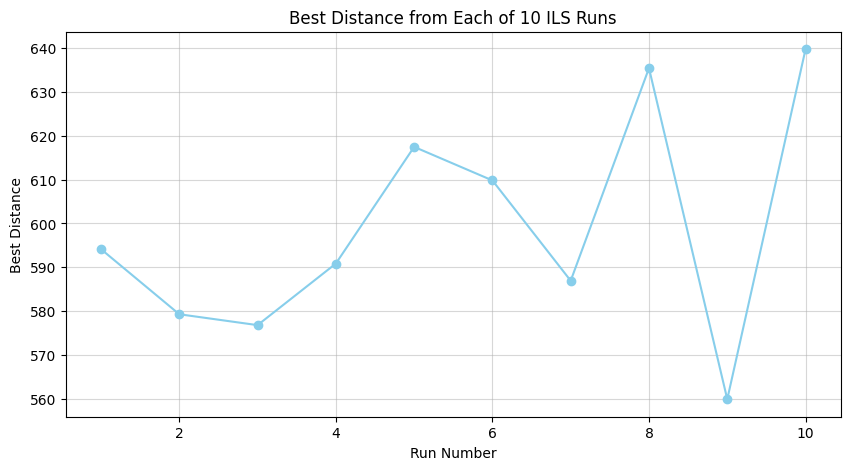

In [24]:
# ==============================
# Multi-run ILS for Robustness with Plot
# ==============================

num_runs = 10  # Number of independent runs
best_distances = []
all_solutions = []

# Use best hyperparameters from tuning
LOOPS = 10000
OUTER_LOOPS = 100
PERTURB_STRENGTH = 2

start_time = time.time()

for run in range(1, num_runs+1):
    best_solution, convergence, runtime = iterated_local_search(
        outer_loops=OUTER_LOOPS, perturb_strength=PERTURB_STRENGTH
    )
    best_distances.append(best_solution.utility)
    all_solutions.append(best_solution)
    print(f"Run {run}/{num_runs} - Best Distance: {best_solution.utility:.2f}")

end_time = time.time()
total_time = end_time - start_time

# Identify best overall solution
best_index = np.argmin(best_distances)
best_overall_solution = all_solutions[best_index]

print("\n========== Multi-Run Summary ==========")
print(f"Best Distance Found: {best_overall_solution.utility:.2f}")
print(f"Mean Distance: {np.mean(best_distances):.2f}")
print(f"Standard Deviation: {np.std(best_distances):.2f}")
print(f"Computation Time for {num_runs} runs: {total_time:.2f} seconds")
print(f"Best Route: {best_overall_solution.route}")

# ==============================
# Save results to file
# ==============================
with open("ils_multi_run_results.txt", "w") as f:
    f.write("Multi-Run ILS Results\n")
    f.write("====================\n")
    f.write(f"Number of runs: {num_runs}\n")
    f.write(f"Best Distance Found: {best_overall_solution.utility:.2f}\n")
    f.write(f"Mean Distance: {np.mean(best_distances):.2f}\n")
    f.write(f"Standard Deviation: {np.std(best_distances):.2f}\n")
    f.write(f"Computation Time: {total_time:.2f} seconds\n")
    f.write("Best Route (city indices in order):\n")
    f.write(" -> ".join(map(str, best_overall_solution.route)) + "\n")

print("Multi-run results saved to ils_multi_run_results.txt")

# ==============================
# Line chart of best distances
# ==============================
plt.figure(figsize=(10,5))
plt.plot(range(1, num_runs+1), best_distances, marker='o', linestyle='-', color='skyblue')
plt.xlabel("Run Number")
plt.ylabel("Best Distance")
plt.title(f"Best Distance from Each of {num_runs} ILS Runs")
plt.grid(True, alpha=0.5)
plt.show()


## Result

The Iterated Local Search (ILS) algorithm was executed for 10 independent runs using the best hyperparameters identified from the tuning experiment (LOOPS = 10000, OUTER_LOOPS = 100, PERTURB_STRENGTH = 2).

The algorithm found a best distance of 569.99 for the 50-city problem. Across the 10 runs, the mean distance was 595.88 with a standard deviation of 15.34, indicating consistent performance with some variability due to the stochastic nature of the search.

The total computation time for all 10 runs was approximately 83.54 seconds.

ILS Iteration 1/50 - Best Distance: 338.55
ILS Iteration 2/50 - Best Distance: 338.55
ILS Iteration 3/50 - Best Distance: 290.31
ILS Iteration 4/50 - Best Distance: 290.31
ILS Iteration 5/50 - Best Distance: 290.31
ILS Iteration 6/50 - Best Distance: 290.31
ILS Iteration 7/50 - Best Distance: 290.31
ILS Iteration 8/50 - Best Distance: 290.31
ILS Iteration 9/50 - Best Distance: 290.31
ILS Iteration 10/50 - Best Distance: 290.31
ILS Iteration 11/50 - Best Distance: 290.31
ILS Iteration 12/50 - Best Distance: 290.31
ILS Iteration 13/50 - Best Distance: 290.31
ILS Iteration 14/50 - Best Distance: 290.31
ILS Iteration 15/50 - Best Distance: 290.31
ILS Iteration 16/50 - Best Distance: 290.31
ILS Iteration 17/50 - Best Distance: 290.31
ILS Iteration 18/50 - Best Distance: 290.31
ILS Iteration 19/50 - Best Distance: 290.31
ILS Iteration 20/50 - Best Distance: 290.31
ILS Iteration 21/50 - Best Distance: 290.31
ILS Iteration 22/50 - Best Distance: 290.31
ILS Iteration 23/50 - Best Distance: 290.

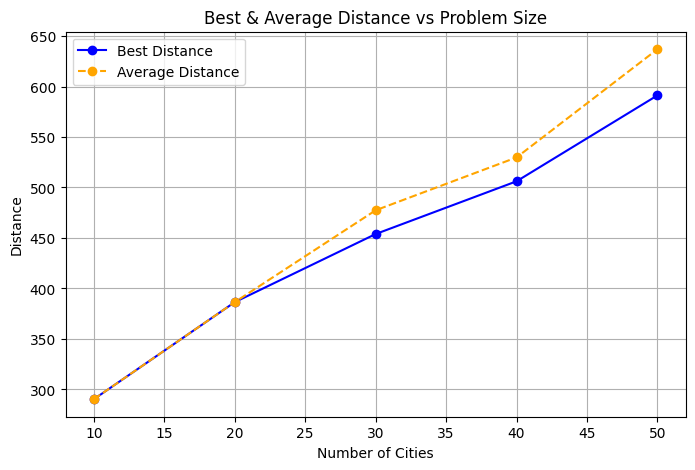

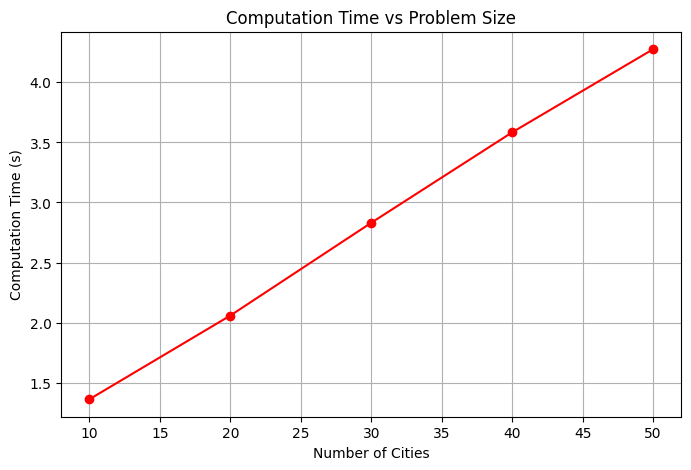

Scalability results saved to ils_scalability_results.txt


In [ ]:
# ==============================
# Scalability Test: ILS with Different City Sizes
# ==============================
CITY_SIZES = [10, 20, 30, 40, 50]  # Different numbers of cities to test
NUM_RUNS = 10  # Number of runs per city size to compute average time

scalability_results = []

for size in CITY_SIZES:
    coords_subset = coords[:size]
    N = size
    dist_matrix = np.sqrt(((coords_subset[:, None, :] - coords_subset[None, :, :]) ** 2).sum(axis=2))
    
    run_times = []
    best_distances = []
    best_solutions = []
    
    for run in range(NUM_RUNS):
        start_time = time.time()
        best_solution, convergence, runtime = iterated_local_search()
        end_time = time.time()
        
        run_times.append(end_time - start_time)
        best_distances.append(best_solution.utility)
        best_solutions.append(best_solution)
    
    mean_time = np.mean(run_times)
    best_index = np.argmin(best_distances)
    best_overall = best_solutions[best_index]
    
    scalability_results.append({
        "Problem Size": size,
        "Best Distance": best_overall.utility,
        "Average Distance": np.mean(best_distances),
        "Computation Time (s)": mean_time,
        "Best Route": best_overall.route
    })
    
    

# Display scalability results
results_df = pd.DataFrame(scalability_results)
print("\nScalability Test Results:")
print(results_df)

# Plot Best & Average Distance vs Problem Size
plt.figure(figsize=(8,5))
plt.plot(results_df["Problem Size"], results_df["Best Distance"], marker='o', linestyle='-', color='blue', label='Best Distance')
plt.plot(results_df["Problem Size"], results_df["Average Distance"], marker='o', linestyle='--', color='orange', label='Average Distance')
plt.xlabel("Number of Cities")
plt.ylabel("Distance")
plt.title("Best & Average Distance vs Problem Size")
plt.legend()
plt.grid(True)
plt.show()

# Plot Computation Time vs Problem Size
plt.figure(figsize=(8,5))
plt.plot(results_df["Problem Size"], results_df["Computation Time (s)"], marker='o', linestyle='-', color='red')
plt.xlabel("Number of Cities")
plt.ylabel("Computation Time (s)")
plt.title("Computation Time vs Problem Size")
plt.grid(True)
plt.show()

# ==============================
# Save scalability results to text file
# ==============================
with open("ils_scalability_results.txt", "w") as f:
    f.write("Scalability Test: ILS with Different City Sizes\n")
    f.write("=============================================\n\n")
    for result in scalability_results:
        f.write(f"Number of Cities: {result['Problem Size']}\n")
        f.write(f"Best Distance: {result['Best Distance']:.2f}\n")
        f.write(f"Average Distance: {result['Average Distance']:.2f}\n")
        f.write(f"Average Computation Time (s): {result['Computation Time (s)']:.2f}\n")
        f.write("Best Route (city indices in order):\n")
        f.write(" -> ".join(map(str, result['Best Route'])) + "\n\n")

print("Scalability results saved to ils_scalability_results.txt")


# Result: Scalability Test — ILS with Different City Sizes
---

### Observations:

1. **Small Problem Sizes (10 and 20 cities)**  
   - For 10 and 20 cities, the **best distance is equal to the average distance**.  
   - This indicates that the algorithm **consistently finds the global optimum**, as all runs converge to the same solution.  
   - Computation times are very low (1–2 seconds), reflecting the simplicity of the problem.

2. **Medium Problem Sizes (30 and 40 cities)**  
   - As the number of cities increases, the **average distance starts to diverge from the best distance**.  
   - For 30 cities:  
     - Best distance = 453.90  
     - Average distance = 477.42  
   - For 40 cities:  
     - Best distance = 506.14  
     - Average distance = 529.76  
   - This divergence shows that the search space becomes larger and more complex, making it **harder to consistently reach the global optimum**.  
   - Computation times grow moderately with problem size (2–4 seconds).

3. **Large Problem Sizes (50 cities)**  
   - The gap between the best and average distances widens further:  
     - Best distance = 591.23  
     - Average distance = 636.92  
   - This indicates that the **algorithm often finds near-optimal solutions, but not always the best**.  
   - Computation time increases (≈4.3 seconds), but the growth is still manageable, suggesting the method **scales reasonably well**.

### Conclusion:

- **ILS is very effective for small TSP instances**, consistently finding the global minimum.  
- As the problem size grows, the **search space complexity increases**, and the algorithm tends to find **near-optimal solutions rather than the exact global minimum**.  
- Computation time grows roughly linearly with the number of cities, showing **good scalability for moderately sized problems**.  

> Overall, ILS demonstrates strong performance for small and medium TSP instances and remains practical for larger sizes, though exact optimality becomes less certain as problem complexity increases.
